In [2]:
import os 
import pandas as pd
import numpy as np
import sys 
import tensorflow as tf

from IPython.core.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
qtf.utils.set_gpu_memory_growth()


# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

In [3]:
# if new methods are created in referenced codes, run the following code.
%reload_ext autoreload

## 数据准备

### 数据获取和清理

In [4]:
print('-'*25, '读取数据', '-'*25)
df_spam = pd.read_csv("data/spam.csv",encoding='ISO-8859-1')
print(df_spam.shape)
display(df_spam.head(5))

print('-'*25, '清理数据', '-'*25)
df_spam.drop(df_spam.columns[2:], axis=1, inplace=True)
df_spam=df_spam.dropna()                                                           
df_spam=df_spam.reset_index(drop=True) 
df_spam.columns = ["label", "text"]

display(df_spam.head(5))
print(df_spam.shape)

# 设置标签
df_spam['label'] = df_spam['label'].map({'ham':0,'spam':1})
display(df_spam.head(5))


------------------------- 读取数据 -------------------------
(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


------------------------- 清理数据 -------------------------


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


(5572, 2)


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### BertTokenizer处理

In [5]:
print('-'*25, 'BertTokenizer处理', '-'*25)

# 加载tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

sentences=list(df_spam['text'])
labels=np.array(df_spam['label'])

input_ids=[]
attention_masks=[]

encoded = bert_tokenizer.batch_encode_plus(batch_text_or_text_pairs=sentences, 
                                            add_special_tokens=True, 
                                            max_length=64, 
                                            truncation=True, 
                                            padding='max_length', 
                                            return_attention_mask=True,
                                            return_tensors='np') 
input_ids = encoded['input_ids']
attention_masks = encoded['attention_mask']

print(f'input_ids.shape={input_ids.shape}')
print(f'attention_masks.shape={attention_masks.shape}')
print(f'labels.shape={labels.shape}')

------------------------- BertTokenizer处理 -------------------------
input_ids.shape=(5572, 64)
attention_masks.shape=(5572, 64)
labels.shape=(5572,)


In [7]:
attention_masks[0:2]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 生成训练测试数据

In [5]:
print('-'*25, '生成训练测试数据', '-'*25)
train_test_data = train_test_split(input_ids, attention_masks, labels, 
                                   test_size=0.2, random_state=202109) 
train_input_ids, test_input_ids = train_test_data[0:2]
train_attention_masks, test_attention_masks = train_test_data[2:4]
train_labels, test_labels = train_test_data[4:6]

print(f'len(train_input_ids)={len(train_input_ids)}, len(test_input_ids)={len(test_input_ids)}')
print(f'len(train_attention_masks)={len(train_attention_masks)}, len(test_attention_masks)={len(test_attention_masks)}')
print(f'len(train_labels)={len(train_labels)}, len(test_labels)={len(test_labels)}')

------------------------- 生成训练测试数据 -------------------------
len(train_input_ids)=4457, len(test_input_ids)=1115
len(train_attention_masks)=4457, len(test_attention_masks)=1115
len(train_labels)=4457, len(test_labels)=1115


## 模型生成和训练

In [6]:
bmodel = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
def get_model():
    inputs = Input(shape=(64,), dtype="int32")
    bert = bmodel(inputs)
    outputs = Dense(units=1, activation="sigmoid")(bert[1])
    model = Model(inputs, outputs)

    adam = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=adam)
    return model 
    
model = get_model()
model.summary()

2021-09-28 06:01:08,779: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 06:01:08,872: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10


2021-09-28 06:01:10,751: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 06:01:10,832: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 06:01:17,306: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 06:01:17,392: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


140/140 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9767WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 06:02:17,678: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 06:02:17,775: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


140/140 [==============================] - 74s 414ms/step - loss: 0.0541 - accuracy: 0.9767 - val_loss: 0.0385 - val_accuracy: 0.9874
Epoch 2/10
140/140 [==============================] - 55s 392ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.0345 - val_accuracy: 0.9919
Epoch 3/10
140/140 [==============================] - 55s 393ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0293 - val_accuracy: 0.9919
Epoch 4/10
140/140 [==============================] - 55s 393ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0946 - val_accuracy: 0.9794
Epoch 5/10
140/140 [==============================] - 55s 394ms/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0265 - val_accuracy: 0.9910
Epoch 6/10
140/140 [==============================] - 55s 393ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0338 - val_accuracy: 0.9928
Epoch 7/10
140/140 [==============================] - 55s 393ms/step - loss: 2.6367e-04 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy:

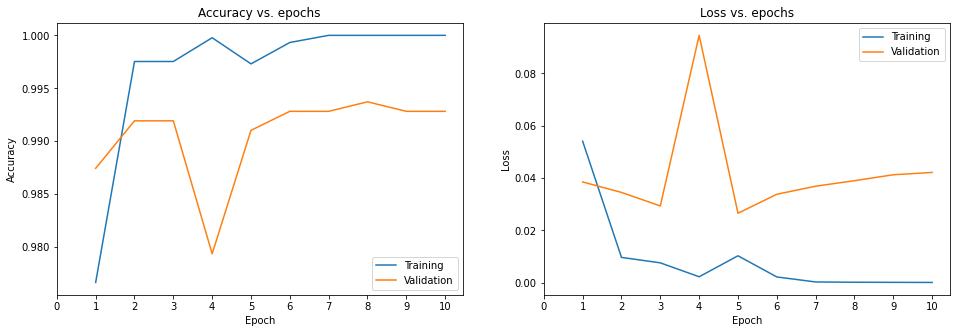

In [10]:
history = model.fit(train_input_ids, train_labels, validation_data=(test_input_ids, test_labels), 
                    batch_size=32, epochs=10)
qtf.utils.plot_history(history, key_metric_name='accuracy')

## 评估和预测